<a href="https://colab.research.google.com/github/PashaIanko/Kaggle.Spaceship-Titanic/blob/main/3_model_preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
from google.colab import drive

import numpy as np

import pandas as pd

import os

from sklearn.model_selection import cross_val_score

In [2]:
# optuna for hyperparameter turning
try:
  import optuna
except ModuleNotFoundError:
  !pip install optuna 

import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances
optuna.logging.set_verbosity(optuna.logging.WARNING)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 16.0 MB/s 
     |████████████████████████████████| 209 kB 68.6 MB/s 
     |████████████████████████████████| 81 kB 8.2 MB/s 
     |████████████████████████████████| 78 kB 7.2 MB/s 
     |████████████████████████████████| 147 kB 61.1 MB/s 
     |████████████████████████████████| 50 kB 5.9 MB/s 
     |████████████████████████████████| 112 kB 72.9 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=a1a80809e623fdfd6231378d711d7eee6ef92777a131c524a901429d71aa3475
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [3]:
%%capture
!pip install catboost

## PEP8 standard

In [4]:
%%capture
!pip install pycodestyle
!pip install --index-url https://test.pypi.org/simple/ nbpep8

from nbpep8.nbpep8 import pep8

## Importing custom packages

In [5]:
%%capture
def download_files(url_dict):
    for file, url in url_dict.items():
        !wget -O {file} {url} {file}


git_download_path = \
    'https://raw.githubusercontent.com/PashaIanko/Sklearn-Utils/main/'

files = [
    'path_manager.py',
    'sklearn_transformers.py',
    'sklearn_utils.py',
    'model.py'
]

url_dict = {file: git_download_path + file for file in files}
download_files(url_dict)

In [6]:
import importlib
import path_manager
import sklearn_utils
import sklearn_transformers
import model


def reload_modules(modules):
    for module in modules:
        importlib.reload(module)


reload_modules(
    [
        path_manager,
        sklearn_transformers,
        sklearn_utils,
        model
    ]
)

from path_manager import PathManager
from sklearn_transformers import ColumnDropper
from sklearn_utils import inf_statistics
from model import Model
from sklearn_utils import fit_grid_search
from sklearn_utils import dict_subset

# Set up paths

In [7]:
drive.mount('/content/gdrive')
gdrive_path = '/content/gdrive/MyDrive/'

PREPROC_TRIAL = 10
MODELS_TRIAL = 10
COMPETITION_PATH = gdrive_path + 'ML/Competitions/6.SpaceshipTitanic/'

manager = PathManager(
    competition_path=COMPETITION_PATH,
    preprocessing_trial=PREPROC_TRIAL,
    models_trial=MODELS_TRIAL
)
manager.setup_paths()

Mounted at /content/gdrive
/content/gdrive/MyDrive/ML/Competitions/6.SpaceshipTitanic/Data/preproc_trial_10 already exists
/content/gdrive/MyDrive/ML/Competitions/6.SpaceshipTitanic/Models/trial_10 already exists


# Fixing seed

In [8]:
RANDOM_SEED = 42
RANDOM_STATE = RANDOM_SEED

np.random.seed(42)

# Download the data

In [9]:
os.listdir(manager.data_trial_path)

['trainval_processed.csv', 'test_sample_processed.csv', 'test_processed.csv']

In [10]:
df_trainval = pd.read_csv(
    os.path.join(
        manager.data_trial_path,
        'trainval_processed.csv'
    ),
    index_col='Unnamed: 0'
)
print(df_trainval.shape)

X_trainval = df_trainval.values[:, :-1]
Y_trainval = df_trainval.values[:, -1]

(6954, 24)


In [11]:
df_test_sample = pd.read_csv(
    os.path.join(
        manager.data_trial_path,
        'test_sample_processed.csv'
    ),
    index_col='Unnamed: 0'
)
print(df_test_sample.shape)

X_test_sample = df_test_sample.values[:, :-1]
Y_test_sample = df_test_sample.values[:, -1]

(1739, 24)


In [12]:
df_trainval.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,-0.459516,-0.409755,-0.441999,-0.429520,-0.426892,-0.689617,-0.587588,-1.826866,1.0,0.0,...,0.857143,0.071038,0.0,0.0,2.392570,-0.277637,1.0,3.130413,0.0,1.0
1,-0.459516,-0.409755,-0.441999,-0.429520,-0.426892,-0.689617,-0.806212,-0.857321,1.0,0.0,...,0.857143,-0.777867,0.0,1.0,-0.490454,-1.226031,1.0,-0.650221,0.0,1.0
2,-0.459516,-0.409755,-0.441999,-0.429520,-0.426892,-0.689617,-0.806212,0.485127,1.0,0.0,...,0.857143,1.758954,0.0,1.0,-0.490454,1.716911,0.0,-0.650221,0.0,0.0
3,-0.459516,-0.409755,-0.441999,-0.429520,-0.426892,-0.689617,-0.806212,-0.186097,0.0,1.0,...,0.428571,-0.851082,0.0,1.0,-0.490454,0.304434,1.0,-0.650221,0.0,1.0
4,-0.459516,-0.409755,-0.214310,-0.427099,3.432164,2.296368,2.496800,-1.155642,1.0,0.0,...,0.857143,0.443052,1.0,1.0,-0.490454,0.174835,1.0,-0.650221,1.0,0.0


# Define models

In [13]:
from sklearn.linear_model import LogisticRegression

In [14]:
LogReg = Model(
    LogisticRegression(),
    'LogReg',
    [
        {
            'penalty': ['elasticnet'],
            'C': [0.01, 0.05, 0.1],
            'random_state': [RANDOM_STATE],
            'solver': ['saga'],
            'l1_ratio': [0, 0.01, 0.05]
        }
    ],
    [

    ]
)

In [15]:
from sklearn.ensemble import RandomForestClassifier


RandomForest = Model(
    RandomForestClassifier(),
    'RandomForest',
    [
        {
            'n_estimators': [75, 125],
            'max_depth': [6],
            'bootstrap': [True],
            'max_features': ['sqrt', 'log2'],
            'random_state': [42],
            'n_jobs': [-1]
        }
    ],
    [

    ]
)

In [16]:
from sklearn.svm import SVC


SVM = Model(
    SVC(),
    'SVM',
    [
        {
            'C': [0.05, 0.1, 0.5, 1.0],
            'kernel': ['linear', 'rbf', 'poly'],
            'random_state': [RANDOM_STATE]
        }
    ],
    [
        
    ]
)

In [17]:
from lightgbm import LGBMClassifier


light_gbm_model = Model(
    LGBMClassifier(),
    'LGBM',
    [
        {
            'objective': ['binary'],
            'random_state': [RANDOM_STATE],
            'boosting': ['dart'],
            'learning_rate': [0.1, 0.15],
            'max_depth': [3, 4],
            'n_estimators': [100, 150, 300],
            'lambda_l1': [0.07],
            'lambda_l2': [0.07]
        }
    ],
    []
)

In [18]:
all_models = {
    model.name: model
    for model in [
        LogReg,
        RandomForest,
        light_gbm_model,
        # SVM
    ]
}

# Shortlist models based on cross-validation behavior

Model           Seen folds avg score    Seen folds std    Unseen folds avg score    Unseen folds std
------------  ----------------------  ----------------  ------------------------  ------------------
LogReg                      0.792673        0.00242217                  0.790049          0.00516871
RandomForest                1               0                           0.795515          0.00832758
LGBM                        0.910771        0.00259223                  0.801843          0.0110457


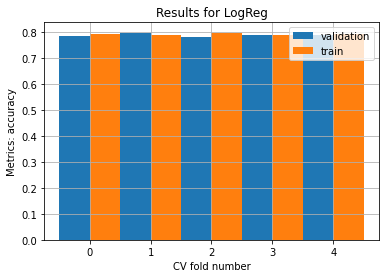

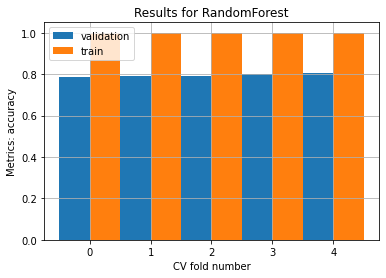

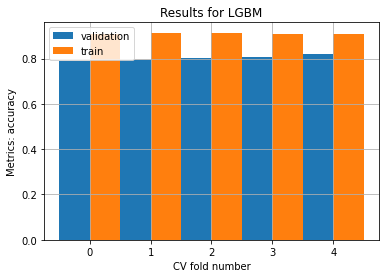

In [ ]:
from sklearn_utils import plot_cv_results


np.random.seed(RANDOM_SEED)

res = plot_cv_results(
    sklearn_models_dict_={
        model_name: model.model
        for model_name, model in all_models.items()
    },
    X_=X_trainval,
    Y_=Y_trainval,
    cv_=5,
    scoring_='accuracy',  # 'accuracy'
    to_put_minus_=False
)

In [ ]:
shortlisted_models = {
    model.name: model
    for model in [
        LogReg,
        # SVM,
        RandomForest,
        light_gbm_model
    ]
}

# Fine tune shortlisted models with grid search

## Random forest

Fitting RandomForest
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END bootstrap=True, max_depth=6, max_features=sqrt, n_estimators=75, n_jobs=-1, random_state=42; total time=   1.9s
[CV] END bootstrap=True, max_depth=6, max_features=sqrt, n_estimators=75, n_jobs=-1, random_state=42; total time=   0.6s
[CV] END bootstrap=True, max_depth=6, max_features=sqrt, n_estimators=75, n_jobs=-1, random_state=42; total time=   0.6s
[CV] END bootstrap=True, max_depth=6, max_features=sqrt, n_estimators=75, n_jobs=-1, random_state=42; total time=   0.6s
[CV] END bootstrap=True, max_depth=6, max_features=sqrt, n_estimators=75, n_jobs=-1, random_state=42; total time=   0.6s
[CV] END bootstrap=True, max_depth=6, max_features=sqrt, n_estimators=125, n_jobs=-1, random_state=42; total time=   0.8s
[CV] END bootstrap=True, max_depth=6, max_features=sqrt, n_estimators=125, n_jobs=-1, random_state=42; total time=   0.8s
[CV] END bootstrap=True, max_depth=6, max_features=sqrt, n_estimators=

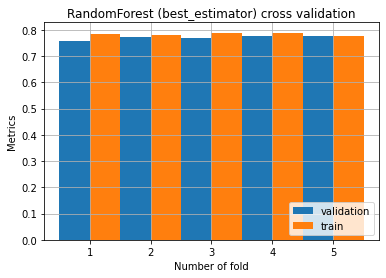

In [ ]:
rf_results = fit_grid_search(
    models_dict_=dict_subset(
        shortlisted_models,
        ['RandomForest']
    ),
    X_=X_trainval,
    Y_=Y_trainval,
    cv_=5,
    scoring_='accuracy',
    verbose=2
)

In [ ]:
rf_results['RandomForest'].best_score_, \
    rf_results['RandomForest'].best_params_

(0.7712117466343245,
 {'bootstrap': True,
  'max_depth': 6,
  'max_features': 'sqrt',
  'n_estimators': 75,
  'n_jobs': -1,
  'random_state': 42})

## SVM

In [ ]:
from sklearn.svm import SVC

svm_model = Model(
    SVC(),
    'SVM',
    [
        {
            'random_state': [42],
            'kernel': ['linear', 'rbf']
        },
    ],
    []
)

Fitting SVM
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5] END kernel=linear, random_state=42;, score=(train=0.791, test=0.772) total time=   2.0s
[CV 2/5] END kernel=linear, random_state=42;, score=(train=0.786, test=0.794) total time=   1.9s
[CV 3/5] END kernel=linear, random_state=42;, score=(train=0.789, test=0.772) total time=   2.0s
[CV 4/5] END kernel=linear, random_state=42;, score=(train=0.786, test=0.793) total time=   1.9s
[CV 5/5] END kernel=linear, random_state=42;, score=(train=0.785, test=0.793) total time=   1.8s
[CV 1/5] END kernel=rbf, random_state=42;, score=(train=0.813, test=0.781) total time=   1.7s
[CV 2/5] END kernel=rbf, random_state=42;, score=(train=0.813, test=0.798) total time=   1.7s
[CV 3/5] END kernel=rbf, random_state=42;, score=(train=0.812, test=0.783) total time=   1.7s
[CV 4/5] END kernel=rbf, random_state=42;, score=(train=0.812, test=0.802) total time=   1.7s
[CV 5/5] END kernel=rbf, random_state=42;, score=(train=0.808, test

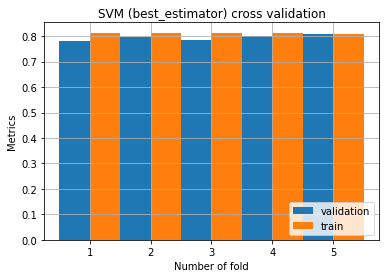

In [ ]:
from sklearn_utils import fit_grid_search


svm_results = fit_grid_search(
    {'SVM': svm_model},
    X_=X_trainval,
    Y_=Y_trainval,
    cv_=5,
    scoring_='accuracy',
    verbose=5
)

In [ ]:
svm_results['SVM'].best_score_

0.7942210200207913

## Gradient boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier


xgb_model = Model(
    GradientBoostingClassifier(),
    'XGB',
    [
        {
            'n_estimators': [100, 150],
            'random_state': [42],
            'learning_rate': [0.05],
            'max_depth': [3],
            'max_features': [None, 'sqrt', 'log2']
        }
    ],
    []
)

Fitting XGB
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END learning_rate=0.05, max_depth=3, max_features=None, n_estimators=100, random_state=42; total time=   1.5s
[CV] END learning_rate=0.05, max_depth=3, max_features=None, n_estimators=100, random_state=42; total time=   1.5s
[CV] END learning_rate=0.05, max_depth=3, max_features=None, n_estimators=100, random_state=42; total time=   1.7s
[CV] END learning_rate=0.05, max_depth=3, max_features=None, n_estimators=100, random_state=42; total time=   1.5s
[CV] END learning_rate=0.05, max_depth=3, max_features=None, n_estimators=100, random_state=42; total time=   1.5s
[CV] END learning_rate=0.05, max_depth=3, max_features=None, n_estimators=150, random_state=42; total time=   2.3s
[CV] END learning_rate=0.05, max_depth=3, max_features=None, n_estimators=150, random_state=42; total time=   2.3s
[CV] END learning_rate=0.05, max_depth=3, max_features=None, n_estimators=150, random_state=42; total time=   2.3s
[CV] END

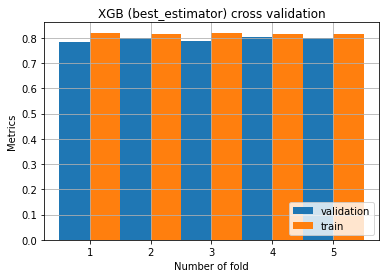

In [ ]:
xgb_results = fit_grid_search(
    models_dict_={'XGB': xgb_model},
    X_=X_trainval,
    Y_=Y_trainval,
    cv_=5,
    scoring_='accuracy',
    verbose=2
)

In [ ]:
xgb_results['XGB'].best_score_, \
    xgb_results['XGB'].best_params_

(0.7955141221314824,
 {'learning_rate': 0.05,
  'max_depth': 3,
  'max_features': None,
  'n_estimators': 150,
  'random_state': 42})

## Adaptive boosting

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier


ada_boost = Model(
    AdaBoostClassifier(),
    'AdaBoost',
    [
        {
            'n_estimators': [50, 100],
            'random_state': [42],
            'base_estimator': [
                # DecisionTreeClassifier(max_depth=2),
                DecisionTreeClassifier(
                    max_depth=3,
                    random_state=RANDOM_STATE,
                    # bootstrap=True
                ),
                # LogisticRegression(random_state=RANDOM_STATE)

            ],
            'learning_rate': [0.05]
        }
    ],
    [

    ]
)

Fitting AdaBoost
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=42), learning_rate=0.05, n_estimators=50, random_state=42; total time=   0.9s
[CV] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=42), learning_rate=0.05, n_estimators=50, random_state=42; total time=   0.9s
[CV] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=42), learning_rate=0.05, n_estimators=50, random_state=42; total time=   0.9s
[CV] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=42), learning_rate=0.05, n_estimators=50, random_state=42; total time=   0.9s
[CV] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=42), learning_rate=0.05, n_estimators=50, random_state=42; total time=   0.9s
[CV] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=42), learning_rate=0.05, n_estimators=100, random_state=42; total time=   2.5s
[CV] END base_es

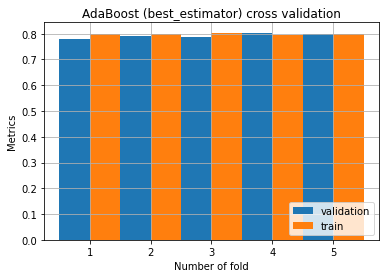

In [ ]:
ada_boost_results = fit_grid_search(
    models_dict_={'AdaBoost': ada_boost},
    X_=X_trainval,
    Y_=Y_trainval,
    cv_=5,
    scoring_='accuracy',
    verbose=2
)

In [ ]:
ada_boost_results['AdaBoost'].best_score_, \
    ada_boost_results['AdaBoost'].best_params_

(0.791488138030194,
 {'base_estimator': DecisionTreeClassifier(max_depth=3, random_state=42),
  'learning_rate': 0.05,
  'n_estimators': 50,
  'random_state': 42})

## CatBoost

In [24]:
from catboost import CatBoostClassifier


cat_boost_model = Model(
    CatBoostClassifier(),
    'CatBoost',
    [
        {
            # 'n_estimators': [150],
            'depth': [5],
            'reg_lambda': [0.01, 0.0],
            'verbose': [0],
            'random_state': [42],
            'iterations': [200, 2000]
        }
    ],
    [
        {
            'n_estimators': [i for i in range(100, 1000)],
            'depth': [i for i in range(2, 15)],
            'random_state': [i for i in range(100)],
            'reg_lambda': [0.001, 0.0001, 0.01, 0.1, 0.00001, 0.0]
        }
        
     
    ]
)

In [26]:
from sklearn_utils import fit_randomized_search

TypeError: ignored

In [ ]:
cat_boost_results_random = fit_randomized_search(
    {'CatBoost': cat_boost_model},
    X_=X_trainval,
    Y_=Y_trainval,
    cv_=5,
    scoring_='accuracy',
    n_iter_=10
)

Fitting CatBoost
0:	learn: 0.6687397	total: 376ms	remaining: 5m 34s
1:	learn: 0.6582057	total: 384ms	remaining: 2m 50s
2:	learn: 0.6331927	total: 692ms	remaining: 3m 24s
3:	learn: 0.6038090	total: 932ms	remaining: 3m 26s
4:	learn: 0.5828436	total: 1.16s	remaining: 3m 25s
5:	learn: 0.5625208	total: 1.39s	remaining: 3m 25s
6:	learn: 0.5417185	total: 1.62s	remaining: 3m 23s
7:	learn: 0.5248241	total: 1.88s	remaining: 3m 27s
8:	learn: 0.5142929	total: 2.11s	remaining: 3m 25s
9:	learn: 0.4995133	total: 2.33s	remaining: 3m 24s
10:	learn: 0.4801214	total: 2.56s	remaining: 3m 24s
11:	learn: 0.4677348	total: 2.78s	remaining: 3m 23s
12:	learn: 0.4562001	total: 3.01s	remaining: 3m 22s
13:	learn: 0.4431843	total: 3.25s	remaining: 3m 23s
14:	learn: 0.4295992	total: 3.48s	remaining: 3m 22s
15:	learn: 0.4160945	total: 3.7s	remaining: 3m 21s
16:	learn: 0.4053173	total: 3.94s	remaining: 3m 22s
17:	learn: 0.3947069	total: 4.17s	remaining: 3m 21s
18:	learn: 0.3900798	total: 4.4s	remaining: 3m 21s
19:	lea

Fitting CatBoost
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END depth=5, iterations=200, random_state=42, reg_lambda=0.01, verbose=0; total time=   1.4s
[CV] END depth=5, iterations=200, random_state=42, reg_lambda=0.01, verbose=0; total time=   0.8s
[CV] END depth=5, iterations=200, random_state=42, reg_lambda=0.01, verbose=0; total time=   0.8s
[CV] END depth=5, iterations=200, random_state=42, reg_lambda=0.01, verbose=0; total time=   0.8s
[CV] END depth=5, iterations=200, random_state=42, reg_lambda=0.01, verbose=0; total time=   0.8s
[CV] END depth=5, iterations=2000, random_state=42, reg_lambda=0.01, verbose=0; total time=   7.0s
[CV] END depth=5, iterations=2000, random_state=42, reg_lambda=0.01, verbose=0; total time=   9.5s
[CV] END depth=5, iterations=2000, random_state=42, reg_lambda=0.01, verbose=0; total time=  13.2s
[CV] END depth=5, iterations=2000, random_state=42, reg_lambda=0.01, verbose=0; total time=  14.3s
[CV] END depth=5, iterations=2000, ra

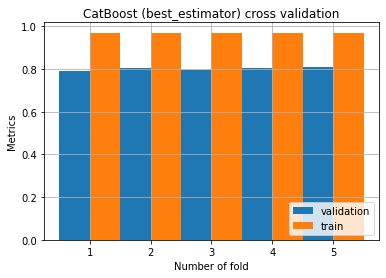

In [22]:
cat_boost_results = fit_grid_search(
    {'CatBoost': cat_boost_model},
    X_=X_trainval,
    Y_=Y_trainval,
    cv_=5,
    scoring_='accuracy',
    verbose=2
)

In [23]:
cat_boost_results['CatBoost'].best_score_, \
    cat_boost_results['CatBoost'].best_params_

(0.8008352771413352,
 {'depth': 5,
  'iterations': 2000,
  'random_state': 42,
  'reg_lambda': 0.01,
  'verbose': 0})

## LogReg

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Model      Seen folds avg score    Seen folds std    Unseen folds avg score    Unseen folds std
-------  ----------------------  ----------------  ------------------------  ------------------
LogReg                 0.794507        0.00163821                   0.79048          0.00483232


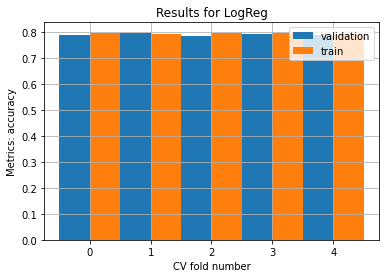

In [ ]:
from sklearn_utils import fit_grid_search


log_reg_results = plot_cv_results(
    {
        'LogReg': LogisticRegression()
    },
    # dict_subset(
    #     shortlisted_models,
    #     ['LogReg']
    # ),
    X_=X_trainval,
    Y_=Y_trainval,
    cv_=5,
    scoring_='accuracy',
    # verbose=1
)

## Light GBM

Fitting LGBM
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END boosting=dart, lambda_l1=0.07, lambda_l2=0.07, learning_rate=0.1, max_depth=3, n_estimators=100, objective=binary, random_state=42;, score=(train=0.805, test=0.776) total time=   0.2s
[CV 2/5] END boosting=dart, lambda_l1=0.07, lambda_l2=0.07, learning_rate=0.1, max_depth=3, n_estimators=100, objective=binary, random_state=42;, score=(train=0.801, test=0.794) total time=   0.2s
[CV 3/5] END boosting=dart, lambda_l1=0.07, lambda_l2=0.07, learning_rate=0.1, max_depth=3, n_estimators=100, objective=binary, random_state=42;, score=(train=0.806, test=0.782) total time=   0.2s
[CV 4/5] END boosting=dart, lambda_l1=0.07, lambda_l2=0.07, learning_rate=0.1, max_depth=3, n_estimators=100, objective=binary, random_state=42;, score=(train=0.799, test=0.803) total time=   0.3s
[CV 5/5] END boosting=dart, lambda_l1=0.07, lambda_l2=0.07, learning_rate=0.1, max_depth=3, n_estimators=100, objective=binary, random_sta

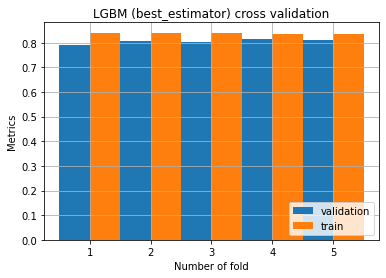

In [ ]:
from sklearn_utils import fit_grid_search


light_gbm_results = fit_grid_search(
    dict_subset(
        all_models,
        ['LGBM']
    ),
    X_=X_trainval,
    Y_=Y_trainval,
    cv_=5,
    scoring_='accuracy',
    verbose=3
)

In [ ]:
light_gbm_results['LGBM'].best_score_, \
    light_gbm_results['LGBM'].best_params_

(0.8042861354338526,
 {'boosting': 'dart',
  'lambda_l1': 0.07,
  'lambda_l2': 0.07,
  'learning_rate': 0.1,
  'max_depth': 4,
  'n_estimators': 300,
  'objective': 'binary',
  'random_state': 42})

## Optuna LGBM

In [ ]:
# instantiate model
def objective_lgbm(trial, X_train=X_trainval, y=Y_trainval):

  param_grid_lgbm = {
      'objective': trial.suggest_categorical('objective', ['binary']),
      'boosting_type': trial.suggest_categorical('boosting_type', ['dart']),
      'learning_rate': trial.suggest_float('learning_rate', 0.08, 0.15, step=0.005),
      'num_leaves': trial.suggest_int('num_leaves', 7, 15, step=1),
      'max_depth': trial.suggest_int('max_depth', 5, 15, step=1),
      'n_estimators': trial.suggest_int('n_estimators', 475, 525, step=5),
      'reg_alpha': trial.suggest_float('reg_alpha', 0.25, 0.75, step=0.05), 
      'reg_lambda': trial.suggest_float('reg_lambda', 0.85, 1, step=0.01),
      'min_child_samples': trial.suggest_int('min_child_samples', 1, 25, step=2)
      }

  lgbm_classifier = LGBMClassifier(**param_grid_lgbm)

  score = cross_val_score(lgbm_classifier, X_train, y, n_jobs=-1, cv=5)
  return score.mean()

In [ ]:
study_lgbm = optuna.create_study(direction='maximize')

In [ ]:
%timeit 
study_lgbm.optimize(objective_lgbm, n_trials=10)

In [ ]:
round(study_lgbm.best_value, 4)

0.8059

In [ ]:
optuna_lgbm = LGBMClassifier(**study_lgbm.best_params)
optuna_lgbm.fit(X_trainval, Y_trainval)

LGBMClassifier(boosting_type='dart', learning_rate=0.115, max_depth=12,
               min_child_samples=1, n_estimators=475, num_leaves=7,
               objective='binary', reg_alpha=0.65, reg_lambda=0.95)

In [ ]:
optuna_lgbm_results = {'LGBMOptuna': optuna_lgbm}

## Optuna LogReg

In [ ]:
def objective_logreg(trial, X_train=X_trainval, y=Y_trainval):
    params = {
        'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
        'C' : trial.suggest_loguniform("C", 1e-2, 1),
        'random_state' : trial.suggest_categorical('random_state' , [0, 42, 2021, 555]),
        'solver' : trial.suggest_categorical('solver' , ['lbfgs','liblinear']),
        "n_jobs" : -1
    }
    logreg_classifier = LogisticRegression(**params)

    score = cross_val_score(logreg_classifier, X_train, y, n_jobs=-1, cv=5)
    return score.mean()

In [ ]:
study_logreg = optuna.create_study(direction='maximize')

In [ ]:
%timeit 
study_logreg.optimize(objective_logreg, n_trials=10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  This is separate from the ipykernel 

In [ ]:
round(study_logreg.best_value, 4)

0.7908

## Optuna SVM

In [ ]:
def objective_svm(trial, X_train=X_trainval, y=Y_trainval):
    params = {
        'C' : trial.suggest_loguniform("C", 0.005, 1),
        'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
        'kernel': trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
        'random_state' : trial.suggest_categorical('random_state' , [0, 42, 2021, 555]),
    }
    classifier = SVC(**params)

    score = cross_val_score(classifier, X_train, y, n_jobs=-1, cv=5)
    return score.mean()

In [ ]:
study_svm = optuna.create_study(direction='maximize')

In [ ]:
%timeit 
study_svm.optimize(objective_svm, n_trials=10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  This is separate from the ipykern

In [ ]:
round(study_svm.best_value, 4)

0.7908

## Stacking model

In [ ]:
CatBoostClassifier(**cat_boost_results['CatBoost'].best_params_)

In [ ]:
from sklearn.ensemble import StackingClassifier


stacking_model = Model(
    StackingClassifier(
        estimators = [
            ('catboost', CatBoostClassifier(**cat_boost_results['CatBoost'].best_params_)),
            ('lgbm', LGBMClassifier(**light_gbm_results['LGBM'].best_params_)),
            # ('adaboost', AdaBoostClassifier(**ada_boost_results['AdaBoost'].best_params_))
            ('logreg', LogisticRegression())  # (**log_reg_results['LogReg'].best_params_))
        ]
    ),
    'Stacking',
    [
        {
            'cv': [5]
        }
    ],
    []
)

Fitting Stacking


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


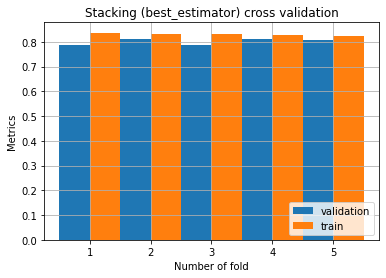

In [ ]:
stacking_results = fit_grid_search(
    {
        'Stacking': stacking_model
    },
    X_=X_trainval,
    Y_=Y_trainval,
    cv_=5,
    scoring_='accuracy'
)

In [ ]:
stacking_results['Stacking'].best_score_

0.7995407268721327

## Voting classifier

In [ ]:
from sklearn.ensemble import VotingClassifier


voting_model = Model(
    VotingClassifier(
        estimators=[
            ('catboost', CatBoostClassifier(**cat_boost_results['CatBoost'].best_params_)),
            ('lgbm', LGBMClassifier(**light_gbm_results['LGBM'].best_params_)),
            ('adaboost', AdaBoostClassifier(**ada_boost_results['AdaBoost'].best_params_))
        ]
    ),
    'voting',
    [
        {
            'n_jobs': [-1],
            'voting': ['hard', 'soft']
        }
    ],
    []
)

Fitting voting
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5] END n_jobs=-1, voting=hard;, score=(train=0.814, test=0.779) total time=   3.7s
[CV 2/5] END n_jobs=-1, voting=hard;, score=(train=0.809, test=0.804) total time=   2.0s
[CV 3/5] END n_jobs=-1, voting=hard;, score=(train=0.811, test=0.790) total time=   2.3s
[CV 4/5] END n_jobs=-1, voting=hard;, score=(train=0.811, test=0.807) total time=   2.1s
[CV 5/5] END n_jobs=-1, voting=hard;, score=(train=0.808, test=0.811) total time=   2.4s
[CV 1/5] END n_jobs=-1, voting=soft;, score=(train=0.816, test=0.781) total time=   3.6s
[CV 2/5] END n_jobs=-1, voting=soft;, score=(train=0.809, test=0.805) total time=   2.1s
[CV 3/5] END n_jobs=-1, voting=soft;, score=(train=0.813, test=0.789) total time=   2.1s
[CV 4/5] END n_jobs=-1, voting=soft;, score=(train=0.813, test=0.807) total time=   2.1s
[CV 5/5] END n_jobs=-1, voting=soft;, score=(train=0.810, test=0.807) total time=   2.1s


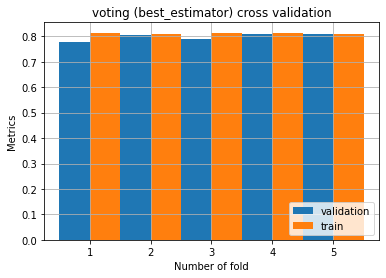

In [ ]:
voting_results = fit_grid_search(
    {'voting': voting_model},
    X_=X_trainval,
    Y_=Y_trainval,
    cv_=5,
    scoring_='accuracy',
    verbose=3
)

In [ ]:
voting_results['voting'].best_score_

0.7983911993338471

# Saving models

In [ ]:
res_models = {
    # **log_reg_results,
    # **xgb_results
    # **light_gbm_results
    # **cat_boost_results
    # **voting_results,
    # **stacking_results,
    **optuna_lgbm_results,
    # **rf_results
}
res_models

{'LGBMOptuna': LGBMClassifier(boosting_type='dart', learning_rate=0.115, max_depth=12,
                min_child_samples=1, n_estimators=475, num_leaves=7,
                objective='binary', reg_alpha=0.65, reg_lambda=0.95)}

In [ ]:
manager.save_models(
    optuna_lgbm_results
)

In [ ]:
manager.save_models(
    {
        f'{model_name}_gridsearch': result.best_estimator_
        for model_name, result in res_models.items()
    }
)